# Cotton Disease Classification with MobileNetV2 (Transfer Learning)

This notebook demonstrates how to use MobileNetV2 with transfer learning for classifying cotton plant diseases into four categories: **bacterial_blight, curl_virus, fussarium_wilt, healthy**.

In [1]:
# 1. Imports and Setup
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import os

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [2]:
# 2. Paths and Hyperparameters

train_dir = 'd:/EfficientNet/Cotton_Dataset/train'
val_dir = 'd:/EfficientNet/Cotton_Dataset/val'
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 10

In [3]:
# 3. Data Loading and Augmentation

train_ds = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=123
)

val_ds = image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 1359 files belonging to 4 classes.
Found 341 files belonging to 4 classes.
Classes: ['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy']


In [4]:
# Check for data imbalance
import os
from collections import Counter

def print_class_distribution(data_dir):
    for split in ['train', 'val']:
        split_dir = os.path.join(data_dir, split)
        print(f"\nClass distribution in {split_dir}:")
        for class_name in os.listdir(split_dir):
            num_images = len(os.listdir(os.path.join(split_dir, class_name)))
            print(f"{class_name}: {num_images}")

print_class_distribution('d:/EfficientNet/Cotton_Dataset')


Class distribution in d:/EfficientNet/Cotton_Dataset\train:
bacterial_blight: 358
curl_virus: 333
fussarium_wilt: 328
healthy: 340

Class distribution in d:/EfficientNet/Cotton_Dataset\val:
bacterial_blight: 90
curl_virus: 84
fussarium_wilt: 82
healthy: 85


In [5]:
# 4. Data Augmentation Layer

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

In [6]:
# 5. Preprocessing Layer for MobileNetV2

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# 6. Build Model with MobileNetV2 Base

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# 7. Train the Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_mobilenetv2_cotton.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint],
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 30s 562ms/step - accuracy: 0.4967 - loss: 1.1860 - val_accuracy: 0.8798 - val_loss: 0.4457
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 509ms/step - accuracy: 0.8901 - loss: 0.4046 - val_accuracy: 0.9179 - val_loss: 0.2861
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 565ms/step - accuracy: 0.8787 - loss: 0.3385 - val_accuracy: 0.9384 - val_loss: 0.2398
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 628ms/step - accuracy: 0.9135 - loss: 0.2624 - val_accuracy: 0.9472 - val_loss: 0.2001
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 579ms/step - accuracy: 0.9291 - loss: 0.2246 - val_accuracy: 0.9531 - val_loss: 0.1805
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 604ms/step - accuracy: 0.9430 - loss: 0.1987 - val_accuracy: 0.9589 - val_loss: 0.1502
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 623ms/step - accuracy: 0.9482 - loss: 0.1790 - val_accuracy: 0.9619 - val_loss: 0.1350
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 608ms/step - accuracy: 0.9540 - loss: 0.1369 - val_accu

In [ ]:
# # Unfreeze the last 30 layers for fine-tuning
# base_model.trainable = True
# for layer in base_model.layers[:-30]:
#     layer.trainable = False

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# history_finetune = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     callbacks=[early_stop, checkpoint]
# )

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 693ms/step - accuracy: 0.8649 - loss: 0.3703 - val_accuracy: 0.9677 - val_loss: 0.1084
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 622ms/step - accuracy: 0.8863 - loss: 0.2767 - val_accuracy: 0.9707 - val_loss: 0.1046
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 706ms/step - accuracy: 0.9395 - loss: 0.2035 - val_accuracy: 0.9707 - val_loss: 0.1018
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 30s 699ms/step - accuracy: 0.9389 - loss: 0.1861 - val_accuracy: 0.9707 - val_loss: 0.1038
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 29s 674ms/step - accuracy: 0.9604 - loss: 0.1379 - val_accuracy: 0.9707 - val_loss: 0.1043
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 29s 669ms/step - accuracy: 0.9588 - loss: 0.1358 - val_accuracy: 0.9736 - val_loss: 0.1021
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 732ms/step - accuracy: 0.9588 - loss: 0.1292 - val_accuracy: 0.9736 - val_loss: 0.1000
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 30s 704ms/step - accuracy: 0.9569 - loss: 0.1260 - val_accu

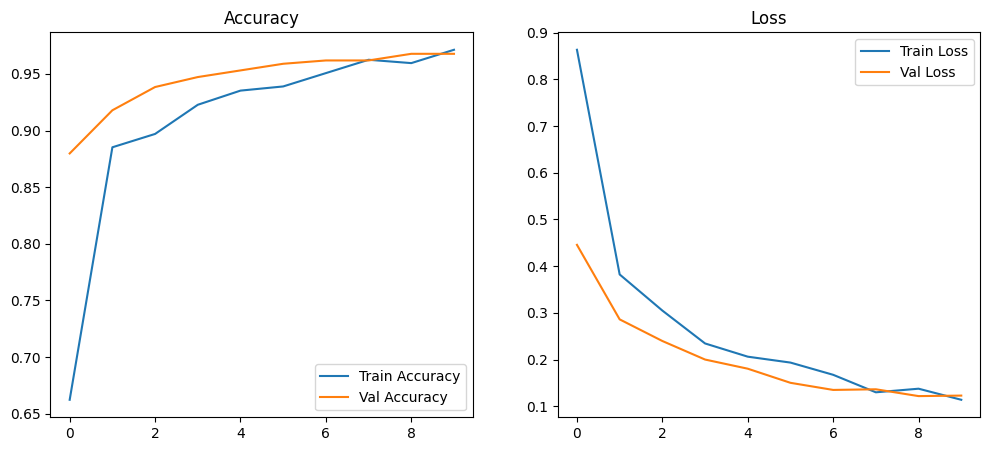

In [10]:
# 8. Plot Accuracy and Loss Curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


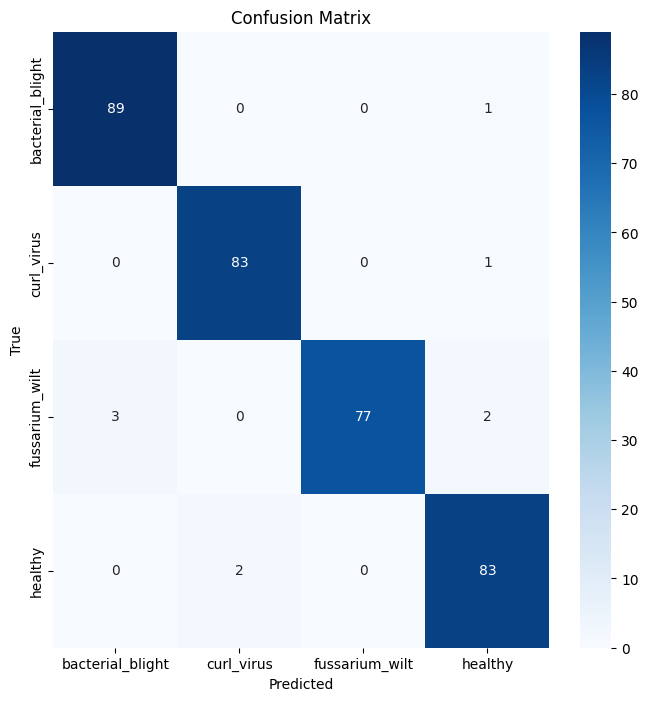

In [11]:
# 9. Confusion Matrix on Validation Set

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted class: healthy
bacterial_blight: 0.87%
curl_virus: 5.55%
fussarium_wilt: 0.40%
healthy: 93.18%


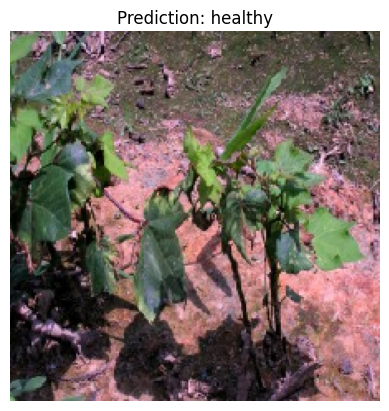

In [17]:
# 10. Predict on a Single Image

from tensorflow.keras.preprocessing import image

def predict_image(image_path, model, class_names, img_size=224):
    img = image.load_img(image_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    print(f'Predicted class: {pred_class}')
    for i, cls in enumerate(class_names):
        print(f'{cls}: {preds[0][i]*100:.2f}%')
    plt.imshow(img)
    plt.title(f'Prediction: {pred_class}')
    plt.axis('off')
    plt.show()

# Example usage:
predict_image(r'D:\EfficientNet\Cotton_Dataset\train\fussarium_wilt\done22.jpg', model, class_names)

## Summary

- This notebook uses MobileNetV2 with transfer learning for cotton disease classification.
- Includes data augmentation, accuracy/loss curves, confusion matrix, and single image prediction.
- Update the `train_dir` and `val_dir` if your dataset is in a different location.